**Extração, Limpeza e Preparação**
Este notebook prepara os dados brutos para a tarefa de detecção de citações. O fluxo de trabalho é dividido em três etapas principais.

Etapa 1: Inventário e Carregamento
Gabarito: O arquivo train_labels.csv é carregado.

Arquivos: Todos os arquivos de artigos (.xml e .pdf) são mapeados e organizados.

Etapa 2: Extração de Conteúdo
Funções de Extração: Foram criadas funções para extrair texto de arquivos XML (mais estruturados) e PDF (como alternativa).

Lógica de Extração: Para cada artigo, o texto é extraído priorizando o arquivo XML. Se não disponível, o PDF é utilizado.

Limpeza: O texto extraído é normalizado para remover espaços, quebras de linha e tabulações em excesso.

Etapa 3: Consolidação e Limpeza
Junção de Dados: As informações do gabarito, os caminhos dos arquivos e o texto extraído são consolidados em um único DataFrame.

Padronização: Os IDs de datasets são normalizados para um formato consistente.

DataFrame Final: É gerado um df_limpo final contendo apenas as colunas essenciais para a análise: article_id, dataset_id, type e texto_do_artigo.

**O resultado é um DataFrame limpo e pronto para a fase de busca de padrões e modelagem.**

In [1]:
!pip install PyMuPDF

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from collections import Counter
import xml.etree.ElementTree as ET
from glob import glob
import fitz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 67.5 MB/s eta 0:00:00:00:0100:01


**1. Configuração Inicial e Carregamento de Dados**

In [2]:
data_root = '/kaggle/input/make-data-count-finding-data-references'
xml_dir = f'{data_root}/train/XML'
pdf_dir = f'{data_root}/train/PDF'
labels_path = f'{data_root}/train_labels.csv'

# Carrega o gabarito
labels_df = pd.read_csv(labels_path)
print(f"Gabarito carregado com {len(labels_df)} linhas.")

Gabarito carregado com 1066 linhas.


**2. Inventário de Arquivos (XML e PDF)**

In [3]:
#Criando inventário de arquivos XML e PDF

# Lista de caminhos
caminhos_dos_arquivos_xml = sorted(glob(f'{xml_dir}/*.xml'))
caminhos_dos_arquivos_pdf = sorted(glob(f'{pdf_dir}/*.pdf'))

# DataFrame para XML
df_xml = pd.DataFrame(caminhos_dos_arquivos_xml, columns=['caminho_xml'])
df_xml['id_do_artigo'] = df_xml['caminho_xml'].apply(lambda p: os.path.basename(p).replace('.xml', ''))

# DataFrame para PDF
df_pdf = pd.DataFrame(caminhos_dos_arquivos_pdf, columns=['caminho_pdf'])
df_pdf['id_do_artigo'] = df_pdf['caminho_pdf'].apply(lambda p: os.path.basename(p).replace('.pdf', ''))

print(f"Encontrados {len(df_xml)} arquivos XML e {len(df_pdf)} arquivos PDF.")

Encontrados 400 arquivos XML e 524 arquivos PDF.


**3. Juntando o Gabarito com os Caminhos de TODOS os Arquivos**

In [4]:
#Juntando o gabarito com os caminhos dos arquivos XML e PDF

# Primeiro, o gabarito com os caminhos XML
df_completo = pd.merge(
    left=labels_df,
    right=df_xml,
    left_on='article_id',
    right_on='id_do_artigo',
    how='left'
)

# Agora, o resultado com os caminhos PDF
df_completo = pd.merge(
    left=df_completo,
    right=df_pdf,
    left_on='article_id',
    right_on='id_do_artigo',
    how='left',
    suffixes=('_xml', '_pdf')
)

# Limpando as colunas de ID duplicadas que foram criadas no merge
colunas_para_remover = df_completo.filter(like='id_do_artigo').columns
df_completo = df_completo.drop(columns=colunas_para_remover)

df_completo.head(3)

,article_id,dataset_id,type,caminho_xml,caminho_pdf
0,10.1002_2017jc013030,https://doi.org/10.17882/49388,Primary,/kaggle/input/make-data-count-finding-data-ref...,/kaggle/input/make-data-count-finding-data-ref...
1,10.1002_anie.201916483,https://doi.org/10.5517/ccdc.csd.cc1npvt0,Missing,/kaggle/input/make-data-count-finding-data-ref...,/kaggle/input/make-data-count-finding-data-ref...
2,10.1002_anie.202005531,https://doi.org/10.5517/ccdc.csd.cc24wxqp,Missing,/kaggle/input/make-data-count-finding-data-ref...,/kaggle/input/make-data-count-finding-data-ref...
3,10.1002_anie.202007717,https://doi.org/10.5517/ccdc.csd.cc24rrb0,Missing,/kaggle/input/make-data-count-finding-data-ref...,/kaggle/input/make-data-count-finding-data-ref...
4,10.1002_chem.201902131,https://doi.org/10.5517/ccdc.csd.cc221dk3,Missing,/kaggle/input/make-data-count-finding-data-ref...,/kaggle/input/make-data-count-finding-data-ref...
...,...,...,...,...,...
1061,10.7717_peerj.12422,https://doi.org/10.15468/dl.t3h8b4,Secondary,/kaggle/input/make-data-count-finding-data-ref...,/kaggle/input/make-data-count-finding-data-ref...
1062,10.7717_peerj.12422,https://doi.org/10.15468/dl.yak5vd,Secondary,/kaggle/input/make-data-count-finding-data-ref...,/kaggle/input/make-data-count-finding-data-ref...
1063,10.7717_peerj.13193,https://doi.org/10.6073/pasta/02e2764efb408a8b...,Secondary,/kaggle/input/make-data-count-finding-data-ref...,/kaggle/input/make-data-count-finding-data-ref...
1064,10.7717_peerj.13193,https://doi.org/10.6073/pasta/275ad28a2f31356c...,Secondary,/kaggle/input/make-data-count-finding-data-ref...,/kaggle/input/make-data-count-finding-data-ref...


**4. Funções para Extrair e LIMPAR Texto de Arquivos XML e PDF**

In [5]:
def extrair_texto_de_xml(caminho_do_arquivo):
    """Lê um arquivo XML, limpa os espaços extras e retorna o texto."""
    if pd.isnull(caminho_do_arquivo):
        return ""
    try:
        arvore = ET.parse(caminho_do_arquivo)
        raiz = arvore.getroot()
        texto_bruto = ' '.join(raiz.itertext())
        # Limpa múltiplos espaços, quebras de linha e tabulações
        texto_limpo = ' '.join(texto_bruto.split())
        return texto_limpo
    except (ET.ParseError, FileNotFoundError):
        return ""

def extrair_texto_de_pdf(caminho_do_arquivo):
    """Lê um arquivo PDF, limpa os espaços extras e retorna o texto."""
    if pd.isnull(caminho_do_arquivo):
        return ""
    try:
        doc = fitz.open(caminho_do_arquivo)
        texto_bruto = ""
        for page in doc:
            texto_bruto += page.get_text()
        doc.close()
        # Limpa múltiplos espaços, quebras de linha e tabulações
        texto_limpo = ' '.join(texto_bruto.split())
        return texto_limpo
    except (RuntimeError, FileNotFoundError):
        return ""


**5. Extração do Texto e Criação da Nova Coluna**

In [6]:
def obter_texto_do_artigo(row):
    """
    Decide qual arquivo usar (XML ou PDF) e extrai o texto.
    Prioriza o XML por ser mais estruturado e confiável.
    """
    texto = extrair_texto_de_xml(row['caminho_xml'])
    if texto: 
        return texto
    else: 
        return extrair_texto_de_pdf(row['caminho_pdf'])

df_completo['texto_do_artigo'] = df_completo.apply(obter_texto_do_artigo, axis=1)

**6. Limpeza e Organização Final**

In [7]:
def normalizar_id_dataset(id_str):
    """Padroniza os IDs de dataset para o formato correto."""
    
    if isinstance(id_str, str):
        # Se for um DOI mas não tiver o prefixo, adiciona
        if id_str.startswith('10.') and not id_str.startswith('https://doi.org/'):
            return f'https://doi.org/{id_str}'
    return id_str

# Aplicando a função de limpeza na coluna 'dataset_id'
df_completo['dataset_id_limpo'] = df_completo['dataset_id'].apply(normalizar_id_dataset)

# Colunas essenciais
colunas_essenciais = [
    'article_id',
    'dataset_id_limpo',
    'type',
    'texto_do_artigo'
]
df_limpo = df_completo[colunas_essenciais].copy()

df_limpo.rename(columns={'dataset_id_limpo': 'dataset_id'}, inplace=True)

df_limpo.head(3)

,article_id,dataset_id,type,texto_do_artigo
0,10.1002_2017jc013030,https://doi.org/10.17882/49388,Primary,Assessing the variability in the relationship ...
1,10.1002_anie.201916483,https://doi.org/10.5517/ccdc.csd.cc1npvt0,Missing,Angew Chem Int Ed Engl Angew. Chem. Int. Ed. E...
2,10.1002_anie.202005531,https://doi.org/10.5517/ccdc.csd.cc24wxqp,Missing,BioC-API 20250509 collection.key PMC7540508 CC...
3,10.1002_anie.202007717,https://doi.org/10.5517/ccdc.csd.cc24rrb0,Missing,Angew Chem Int Ed Engl Angew Chem Int Ed Engl ...
4,10.1002_chem.201902131,https://doi.org/10.5517/ccdc.csd.cc221dk3,Missing,Chemistry Chemistry 10.1002/(ISSN)1521-3765 CH...
...,...,...,...,...
1061,10.7717_peerj.12422,https://doi.org/10.15468/dl.t3h8b4,Secondary,pmc PeerJ PeerJ PeerJ PeerJ 2167-8359 PeerJ In...
1062,10.7717_peerj.12422,https://doi.org/10.15468/dl.yak5vd,Secondary,pmc PeerJ PeerJ PeerJ PeerJ 2167-8359 PeerJ In...
1063,10.7717_peerj.13193,https://doi.org/10.6073/pasta/02e2764efb408a8b...,Secondary,pmc PeerJ PeerJ peerj PeerJ 2167-8359 PeerJ In...
1064,10.7717_peerj.13193,https://doi.org/10.6073/pasta/275ad28a2f31356c...,Secondary,pmc PeerJ PeerJ peerj PeerJ 2167-8359 PeerJ In...


**7. Verificação**

In [8]:
for index, row in df_limpo.head(2).iterrows():
    print(f"\nArtigo ID: {row['article_id']}")
    print(f"Dataset ID (limpo): {row['dataset_id']}")
    texto_artigo = str(row['texto_do_artigo'])
    print(f"Início do texto: {texto_artigo[:100]}...")
    print("-" * 20)


Artigo ID: 10.1002_2017jc013030
Dataset ID (limpo): https://doi.org/10.17882/49388
Início do texto: Assessing the variability in the relationship between the particulate backscattering coefficient and...
--------------------

Artigo ID: 10.1002_anie.201916483
Dataset ID (limpo): https://doi.org/10.5517/ccdc.csd.cc1npvt0
Início do texto: Angew Chem Int Ed Engl Angew. Chem. Int. Ed. Engl 10.1002/(ISSN)1521-3773 ANIE Angewandte Chemie (In...
--------------------


**8. Análise Exploratória: Distribuição dos Tipos de Citação**

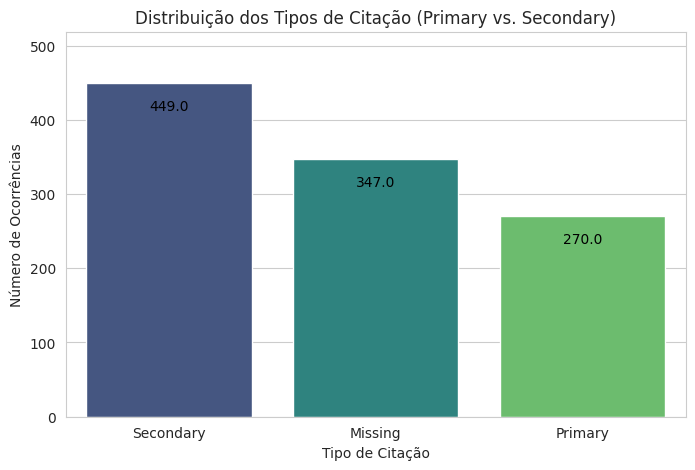


Contagem exata por tipo de citação:
type
Secondary    449
Missing      347
Primary      270
Name: count, dtype: int64


In [15]:

sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

# Cria o gráfico de contagem para a coluna 'type'
# O seaborn conta automaticamente as ocorrências de cada categoria.
# 'order' garante que as barras apareçam em ordem decrescente de contagem.
plot = sns.countplot(
    x='type',
    data=df_limpo,
    order=df_limpo['type'].value_counts().index,
    palette='viridis'
)

# Adiciona os valores exatos no topo de cada barra para clareza
for p in plot.patches:
    plot.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='black', size=10)

# Adiciona título e rótulos aos eixos
plt.title('Distribuição dos Tipos de Citação (Primary vs. Secondary)', fontsize=12)
plt.xlabel('Tipo de Citação', fontsize=10)
plt.ylabel('Número de Ocorrências', fontsize=10)
plt.ylim(0, plt.ylim()[1] * 1.1) # Aumenta o espaço no topo para os rótulos

# Exibe o gráfico
plt.show()

# Para uma análise mais detalhada, também imprimimos os números exatos
print("\nContagem exata por tipo de citação:")
print(df_limpo['type'].value_counts())

In [16]:
!pip install wordcloud

from wordcloud import WordCloud
from nltk.corpus import stopwords

Gerando a nuvem de palavras para uma melhor visualização...


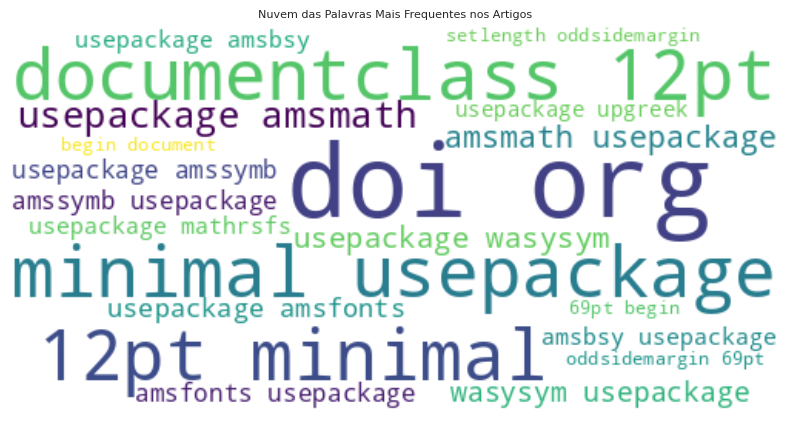

In [23]:
# --- 10. Visualização com Nuvem de Palavras ---
print("Gerando a nuvem de palavras para uma melhor visualização...")

# Pega a lista de stopwords em inglês
stop_words = set(stopwords.words('english'))

# Adicionando palavras comuns em artigos que não agregam valor à nuvem
palavras_extras_para_remover = {'et', 'al', 'fig','https', 'figure', 'table', 'data', 'study', 'results', 'analysis', 'using', 'also'}
stop_words.update(palavras_extras_para_remover)

# Concatena todo o texto da coluna 'texto_do_artigo' em uma única string
corpus_completo = ' '.join(df_limpo['texto_do_artigo'].dropna())

# Converte todo o texto para minúsculas
corpus_completo = corpus_completo.lower()

# Usa expressões regulares para encontrar todas as palavras (tokens)
tokens = re.findall(r'\b\w+\b', corpus_completo)

# Remove as stopwords, números E palavras com apenas 1 caractere (A CORREÇÃO)
palavras_filtradas = [palavra for palavra in tokens if palavra not in stop_words and not palavra.isdigit() and len(palavra) > 1]

# Junta as palavras filtradas de volta em uma única string para a nuvem
texto_para_nuvem = ' '.join(palavras_filtradas)

# Cria o objeto WordCloud com algumas configurações de estilo
wordcloud = WordCloud(
    width=500,
    height=250,
    background_color='white',
    colormap='viridis',
    max_words=20, # Limita o número de palavras na nuvem
    contour_width=3,
    contour_color='steelblue'
).generate(texto_para_nuvem)

# Exibe a nuvem de palavras gerada usando matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") # Remove os eixos x e y
plt.title('Nuvem das Palavras Mais Frequentes nos Artigos', fontsize=8)
plt.show()


ERROR! Session/line number was not unique in database. History logging moved to new session 32


/tmp/ipykernel_36/1687414737.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_coocorr = pd.DataFrame(index=palavras_mais_comuns, columns=palavras_mais_comuns).fillna(0)


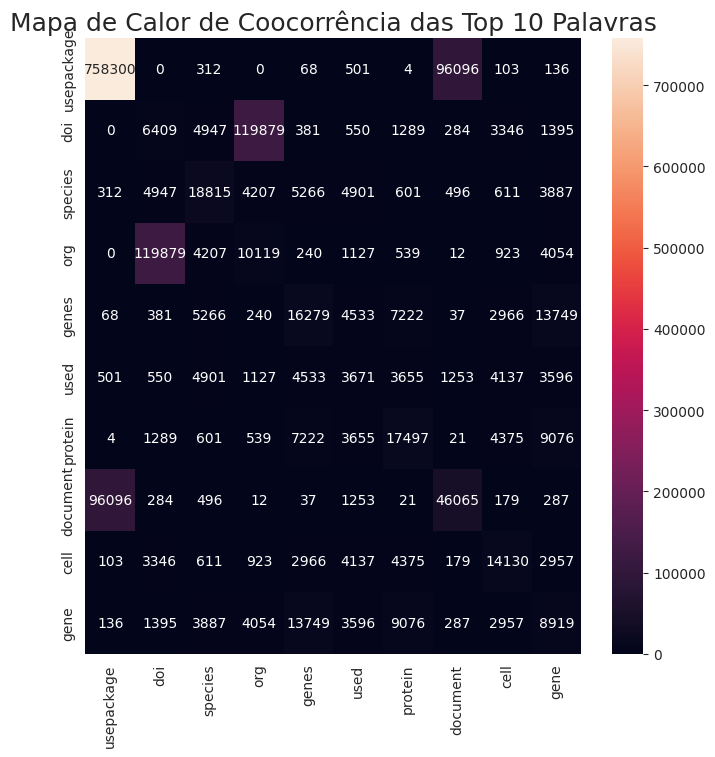

In [27]:
from collections import Counter, defaultdict
import numpy as np
# Pega as 10 palavras mais comuns para a análise de coocorrência
contador_de_palavras = Counter(palavras_filtradas)
palavras_mais_comuns = [palavra for palavra, freq in contador_de_palavras.most_common(10)]

# Cria um dicionário para armazenar as contagens de coocorrência
coocorr_dict = defaultdict(int)
window_size = 10 # Janela de palavras para verificar a coocorrência

# Itera sobre a lista de palavras filtradas para preencher o dicionário
for i in range(len(palavras_filtradas) - window_size):
    window = palavras_filtradas[i : i + window_size]
    for j, palavra1 in enumerate(window):
        if palavra1 in palavras_mais_comuns:
            for k in range(j + 1, len(window)):
                palavra2 = window[k]
                if palavra2 in palavras_mais_comuns:
                    # Ordena para garantir que (p1, p2) e (p2, p1) sejam contados juntos
                    par_ordenado = tuple(sorted((palavra1, palavra2)))
                    coocorr_dict[par_ordenado] += 1

# Cria um DataFrame do pandas para servir como matriz de coocorrência
df_coocorr = pd.DataFrame(index=palavras_mais_comuns, columns=palavras_mais_comuns).fillna(0)

# Preenche o DataFrame com os valores do dicionário
for (p1, p2), contagem in coocorr_dict.items():
    if p1 in df_coocorr.index and p2 in df_coocorr.columns:
        df_coocorr.loc[p1, p2] = contagem
        df_coocorr.loc[p2, p1] = contagem # Preenche a matriz simetricamente

# Cria o mapa de calor (heatmap)
plt.figure(figsize=(8,8))
sns.heatmap(
    df_coocorr,
    annot=True, # Adiciona os números nas células
    fmt="d",    # Formata os números como inteiros
)

plt.title('Mapa de Calor de Coocorrência das Top 10 Palavras', fontsize=18)
plt.show()

In [29]:
# Pega as 10 palavras mais comuns para a análise de coocorrência
contador_de_palavras = Counter(palavras_filtradas)
palavras_mais_comuns = [palavra for palavra, freq in contador_de_palavras.most_common(10)]

# Cria um dicionário para armazenar as contagens de coocorrência
coocorr_dict = defaultdict(int)
window_size = 8 # Janela de palavras para verificar a coocorrência

# Itera sobre a lista de palavras filtradas para preencher o dicionário
for i in range(len(palavras_filtradas) - window_size):
    window = palavras_filtradas[i : i + window_size]
    for j, palavra1 in enumerate(window):
        if palavra1 in palavras_mais_comuns:
            for k in range(j + 1, len(window)):
                palavra2 = window[k]
                if palavra2 in palavras_mais_comuns:
                    # Ordena para garantir que (p1, p2) e (p2, p1) sejam contados juntos
                    par_ordenado = tuple(sorted((palavra1, palavra2)))
                    coocorr_dict[par_ordenado] += 1

# Cria um DataFrame do pandas para servir como matriz de coocorrência
df_coocorr = pd.DataFrame(index=palavras_mais_comuns, columns=palavras_mais_comuns).fillna(0)

# Preenche o DataFrame com os valores do dicionário
for (p1, p2), contagem in coocorr_dict.items():
    if p1 in df_coocorr.index and p2 in df_coocorr.columns:
        df_coocorr.loc[p1, p2] = contagem
        df_coocorr.loc[p2, p1] = contagem # Preenche a matriz simetricamente

# Cria o mapa de calor (heatmap) com as novas configurações
plt.figure(figsize=(6,6))
sns.heatmap(
    df_coocorr,
    annot=True, # Adiciona os números nas células
    fmt="d",    # Formata os números como inteiros
    cmap='red' # MUDANÇA: Paleta de cores para tons de azul
)

plt.title('Mapa de Calor de Coocorrência das Top 10 Palavras', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotaciona os labels do eixo x para melhor leitura
plt.yticks(rotation=0)
plt.show()

/tmp/ipykernel_36/3675542023.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_coocorr = pd.DataFrame(index=palavras_mais_comuns, columns=palavras_mais_comuns).fillna(0)


KeyError: "'red' is not a known colormap name"

<Figure size 600x600 with 0 Axes>

Gerando o histograma para as 15 palavras mais frequentes...


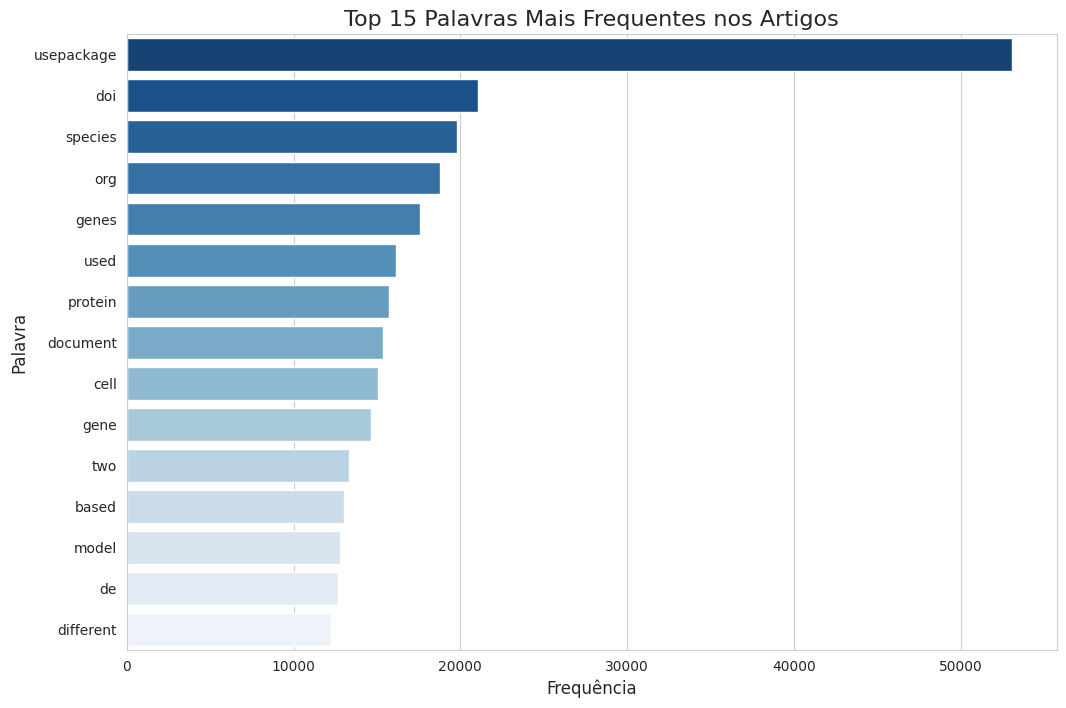


DataFrame com as 15 palavras mais frequentes e suas contagens:
       Palavra  Frequência
0   usepackage       53081
1          doi       21039
2      species       19784
3          org       18780
4        genes       17603
5         used       16129
6      protein       15695
7     document       15383
8         cell       15044
9         gene       14624
10         two       13347
11       based       13002
12       model       12772
13          de       12657
14   different       12250


In [30]:
# --- 12. Histograma das 15 Palavras Mais Frequentes ---
print("Gerando o histograma para as 15 palavras mais frequentes...")

# Este bloco assume que a lista 'palavras_filtradas' já foi gerada em uma célula anterior.

# Conta a frequência de cada palavra
contador_de_palavras = Counter(palavras_filtradas)

# Pega as 15 palavras mais comuns
palavras_mais_comuns = contador_de_palavras.most_common(15)

# Cria um DataFrame com as palavras mais comuns para facilitar a visualização
df_frequencia_15 = pd.DataFrame(palavras_mais_comuns, columns=['Palavra', 'Frequência'])

# Cria o gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Frequência',
    y='Palavra',
    data=df_frequencia_15,
    palette='Blues_r' # Usando uma paleta de azuis reversa para o gradiente
)

# Adiciona título e rótulos
plt.title('Top 15 Palavras Mais Frequentes nos Artigos', fontsize=16)
plt.xlabel('Frequência', fontsize=12)
plt.ylabel('Palavra', fontsize=12)

# Exibe o gráfico
plt.show()

# Imprime o DataFrame para referência
print("\nDataFrame com as 15 palavras mais frequentes e suas contagens:")
print(df_frequencia_15)